> In a sense, there is no such things as a random number. For example, is 2 a random number? Rather, we speak of a sequence of independent random numbers with a specified distribution. -Donald Knuth

编写程序时，我们常常会用到随机数，比如爬虫时随机 Sleep、随机从 UA 池中选择 UA、模拟掷色子等等。那么计算机如何生成随机数呢？

一种方式是通过接受外部输入，继承外部的随机性，比如[盖革计数器](https://zh.wikipedia.org/zh-hans/%E7%9B%96%E9%9D%A9%E8%AE%A1%E6%95%B0%E5%99%A8)。这种方式存在一些缺点。首先是需要外部硬件设备，其次收集分析外部数据可能需要较长时间，最关键的是随机数大概率无法复现，这对于程序调试是一个很大的问题。

第二种方式是使用伪随机数生成器（PRNG）算法。比如 Python 的 random 模块使用马特塞特旋转算法（Mersenne Twister）生成随机数。马特塞特旋转算法基于线性同余生成器，被广泛使用在各类随机数生成器中，但该算法有一个确定的周期，并且需要大量的计算资源。因此自版本 1.17 以来，NumPy 使用更高效的置换同余生成器-64（PCG64）算法。PCG64 算法的周期性更长，产生的数字更难以预测，生成速度更快且需要更少的资源。

# BitGenerator 与 Generator

[`BitGenerator`](https://numpy.org/doc/stable/reference/random/bit_generators/generated/numpy.random.BitGenerator.html#numpy.random.BitGenerator) 类允许我们自定义算法和随机数种子，`Generator` 是 `BitGenerator` 的容器。为了访问随机数，`BitGenerator` 被传递到一个单独的 `Generator` 对象中。`Generator` 具有允许用户访问一系列随机数并执行多个随机化操作的方法。`numpy.random` 模块提供了这种功能。


In [3]:
import numpy as np
from numpy.random import Generator, PCG64

rng = Generator(PCG64())
rng.standard_normal()

-0.7384404676801147

# default_rng

如果你愿意让 NumPy 为你完成所有的随机数生成工作，你可以使用它的默认值。换句话说，你的 BitGenerator 将使用 PCG64，并使用计算机时钟的种子。为了方便使用默认值，NumPy 提供了一个非常方便的 default_rng() 函数。这个函数会为你设置一切，并返回一个 Generator 对象的引用，供你使用其强大方法生成随机数。


In [29]:
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [5]:
rng = default_rng(12345)

## Simple random data

### `random`

`random.Generator.random(size=None, dtype=np.float64, out=None)`

创建一个给定形状的数组，并用 `[0,1)` 均匀分布的随机样本填充它。


In [6]:
rng.random()

0.22733602246716966

In [7]:
rng.random((3, 4))

array([[0.31675834, 0.79736546, 0.67625467, 0.39110955],
       [0.33281393, 0.59830875, 0.18673419, 0.67275604],
       [0.94180287, 0.24824571, 0.94888115, 0.66723745]])

### `integers`

`random.Generator.integers(low, high=None, size=None, dtype=np.int64, endpoint=False)`

创建一个给定形状的数组，并用从 low（包含）到 high（不包含）之间“离散均分”分布的随机整数填充它；如果 `endpoint=True`，则用从 low（包含）到 high（包含）之间的随机整数进行填充。


In [8]:
rng.integers(low=2, high=10, size=(3, 4))

array([[3, 2, 4, 5],
       [2, 9, 5, 7],
       [3, 4, 2, 7]])

如果 high 为 None（默认值），则结果范围从 0 到 low。


In [9]:
rng.integers(5)

3

### `choice`

`random.Generator.choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)`

从给定数组中生成一个随机样本。如果 `a` 是一个整数，则从 `np.arange(a)` 生成样本。


In [10]:
rng.choice(5, 3)

array([1, 3, 0])

如果 `a` 是一个数组，则默认从 `a` 均匀随机采样。


In [11]:
a = rng.integers(low=2, high=20, size=10)
print(a)
rng.choice(a, size=(2, 5))

[ 9  4 15  8 10 10 10  6 12 16]


array([[10,  4,  9,  4,  9],
       [ 9,  4, 10, 12, 12]])

也可以使用参数 `p` 为采样数组中的每个样本确定采样概率。


In [12]:
a = rng.integers(low=2, high=20, size=10)
p = a / sum(a)  # 注意 p 为一个概率分布，满足归一化原理
print(a)
print(p)
rng.choice(a, size=(2, 4), p=p)

[13 12  7 18 13 15 15 17 14 18]
[0.0915493  0.08450704 0.04929577 0.12676056 0.0915493  0.1056338
 0.1056338  0.11971831 0.09859155 0.12676056]


array([[15, 18, 15, 18],
       [15, 17, 18, 18]])

如果采样数组 `a` 的维数超过了 1，那么 `size` 参数将会沿轴 0 插入。比如 `a.shape=(2,5)`，`size=(3,4)`，则采样生成的数组 `b.shape=(3,4,5)`。


In [13]:
a = rng.integers(low=2, high=20, size=(2, 5))
b = rng.choice(a, size=(3, 4))
print(b)  # b.shape=(3,4,5)

[[[10  6  7  8 13]
  [ 6 17  8  3  2]
  [10  6  7  8 13]
  [10  6  7  8 13]]

 [[ 6 17  8  3  2]
  [10  6  7  8 13]
  [ 6 17  8  3  2]
  [ 6 17  8  3  2]]

 [[10  6  7  8 13]
  [10  6  7  8 13]
  [10  6  7  8 13]
  [10  6  7  8 13]]]


## Permutations

### `shuffle`

`random.Generator.shuffle(x, axis=0)`

对所给数组进行重新排列（inplace）。


In [14]:
x = np.arange(10)
print(x)
rng.shuffle(x)
print(x)

[0 1 2 3 4 5 6 7 8 9]
[6 2 7 4 0 5 8 9 3 1]


可以利用 `axis` 参数指定沿着哪个轴随机排列，`axis=1` 表示每列作为一个整体随机排列。


In [15]:
x = np.arange(12).reshape((3, 4))
print(x)
rng.shuffle(x, axis=1)
print(x)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[[ 1  2  0  3]
 [ 5  6  4  7]
 [ 9 10  8 11]]


### `permutation`

`random.Generator.permutation(x, axis=0)`

如果参数 `x` 是一个整数，则随机排列 `np.arange(x)`：


In [16]:
rng.permutation(10)

array([0, 1, 5, 9, 6, 7, 8, 3, 4, 2])

如果参数 `x` 是一个数组，先做一份拷贝，然后随机打乱元素的顺序：


In [17]:
x = np.arange(12).reshape((3, 4))
print(x)
rng.permutation(x)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([[ 0,  1,  2,  3],
       [ 8,  9, 10, 11],
       [ 4,  5,  6,  7]])

### `permuted`

`random.Generator.permuted(x, axis=None, out=None)`

沿着指定的轴（axis）随机排列数组 `x`：


In [18]:
x = np.arange(12).reshape((3, 4))
rng.permuted(x)

array([[ 3,  0,  8,  7],
       [ 1,  2, 11,  6],
       [ 9,  5, 10,  4]])

使用 `out` 参数原地排列：


In [19]:
x = np.arange(12).reshape((3, 4))
rng.permuted(x, out=x)
x

array([[ 5, 10,  3,  6],
       [ 8,  0,  2,  9],
       [11,  1,  4,  7]])

使用 `axis=1` 参数可以对每行内的值（即沿着 axis=1 的值）独立地进行排列。


In [20]:
x = np.arange(12).reshape((3, 4))
rng.permuted(x, axis=1)

array([[ 3,  1,  0,  2],
       [ 6,  5,  7,  4],
       [10,  9, 11,  8]])

## 概率分布

### 均匀分布

`random.Generator.uniform(low=0.0, high=1.0, size=None)`


In [21]:
rng.uniform(-2, 3, size=(3, 4))

array([[-1.95143936, -0.94978521,  2.35000339,  2.86414901],
       [ 0.20896172, -0.10625253, -0.62026459,  2.83052055],
       [-1.70898697,  0.04366949, -1.15685578, -0.79927971]])

In [44]:
def my_plotter(ax, data1, bins, param_dict):
    """
    A helper function to make a graph.
    """
    n, bins, patches = ax.hist(data1, bins=bins, density=True, **param_dict)
    return n, bins, patches

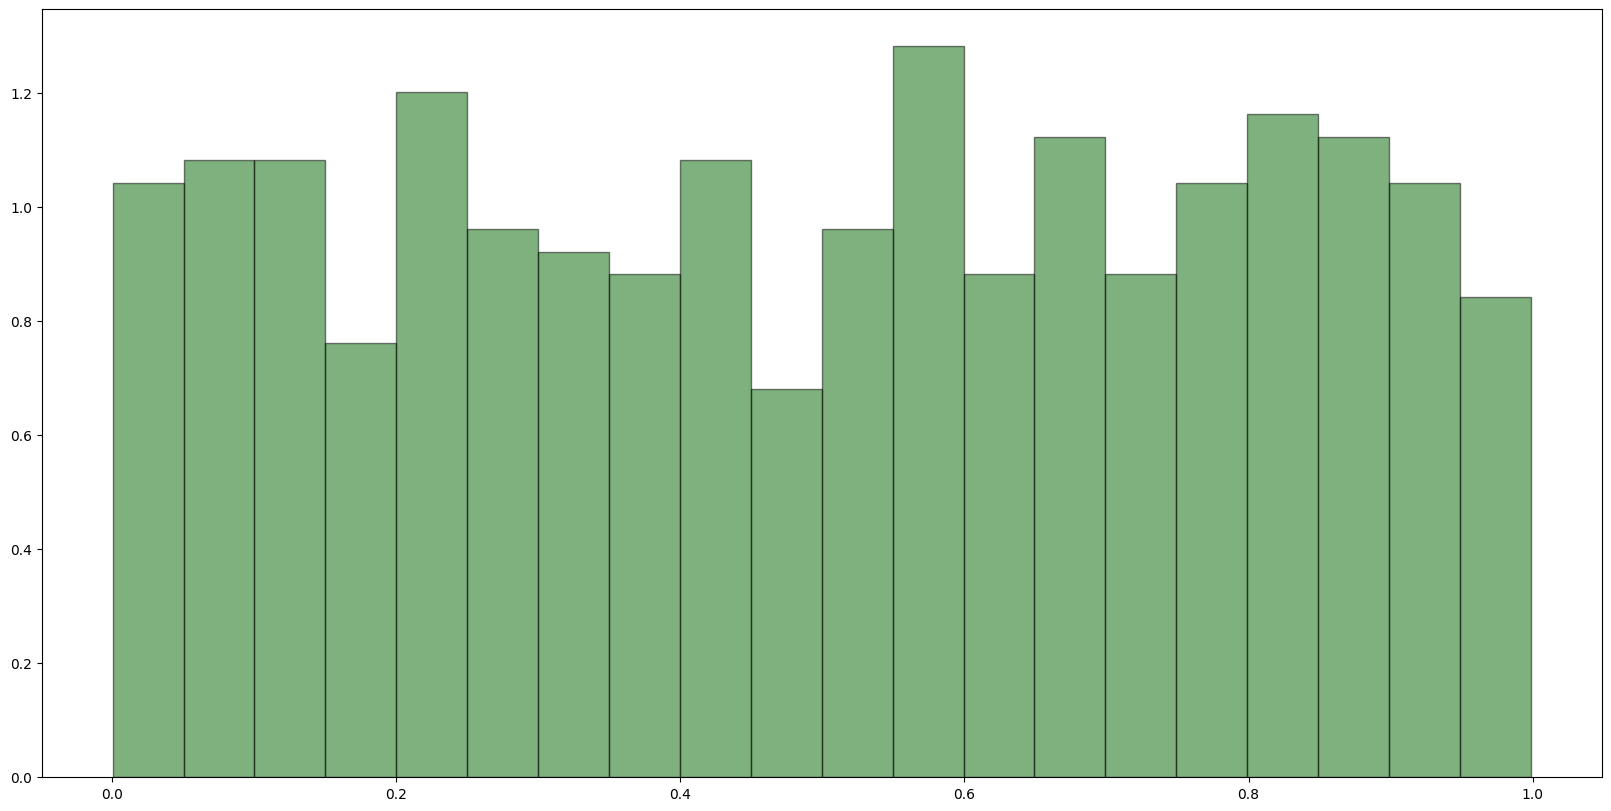

In [51]:
fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")

res = my_plotter(
    ax,
    rng.uniform(0, 1, size=500),
    20,
    {"color": "darkgreen", "edgecolor": "black", "alpha": 0.5},
)

### 二项分布

`random.Generator.binomial(n, p, size=None)`


In [22]:
rng.binomial(10, 0.5, 20)

array([6, 4, 5, 4, 5, 4, 4, 4, 3, 5, 7, 8, 2, 7, 3, 6, 7, 3, 4, 5])

In [23]:
rng.binomial(10, 0.5, (4, 5))

array([[4, 5, 1, 5, 7],
       [3, 5, 5, 6, 8],
       [6, 4, 6, 4, 6],
       [6, 8, 7, 2, 4]])

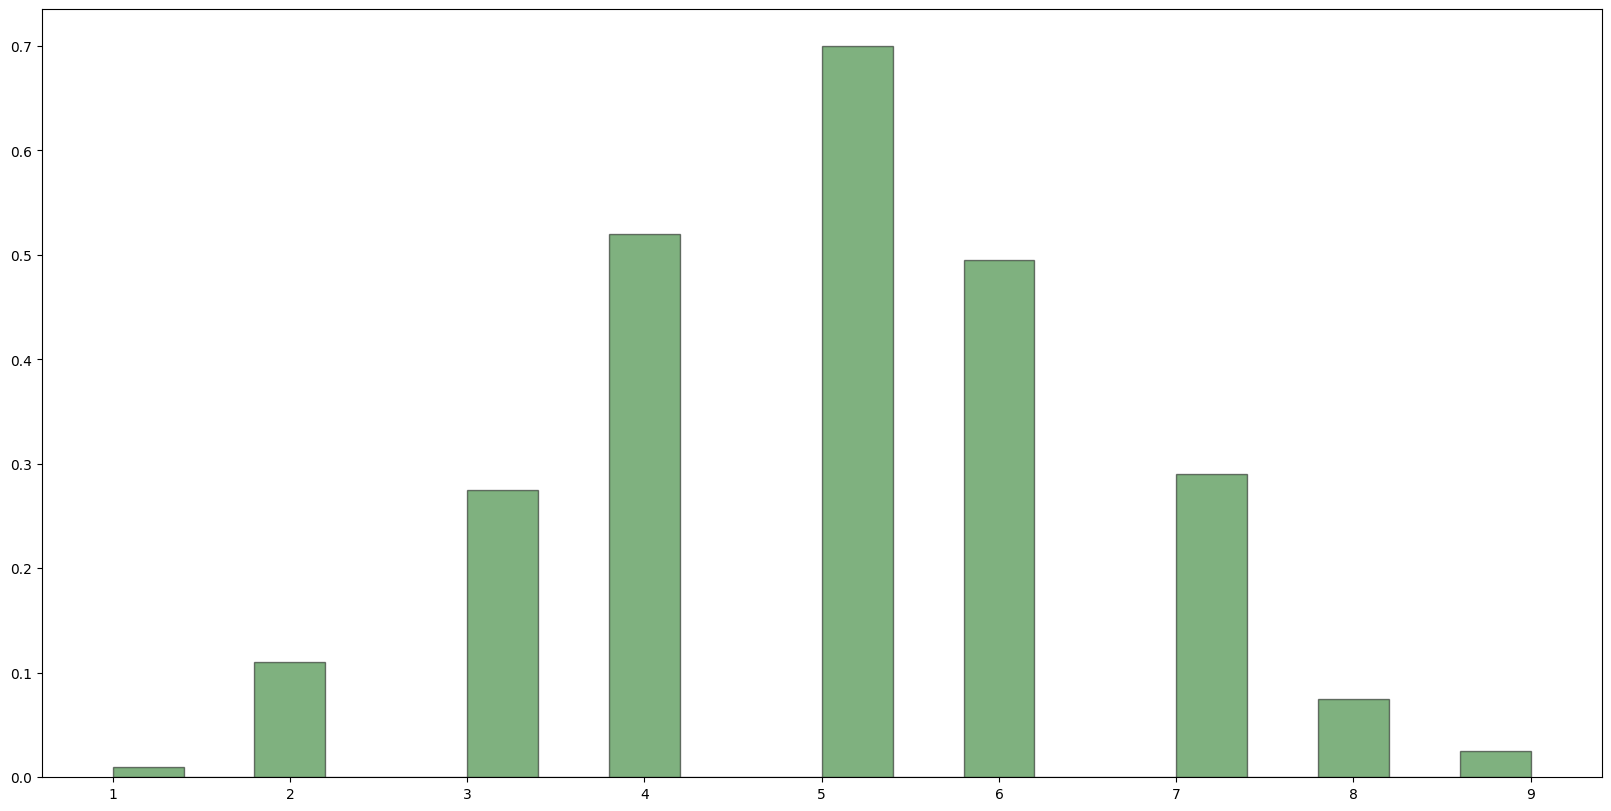

In [50]:
fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")

res = my_plotter(
    ax,
    rng.binomial(10, 0.5, 500),
    20,
    {"color": "darkgreen", "edgecolor": "black", "alpha": 0.5},
)

### 几何分布

`random.Generator.geometric(p, size=None)`


In [24]:
rng.geometric(0.1, 10)

array([14,  4,  2,  1,  4,  1,  5,  4,  5,  2])

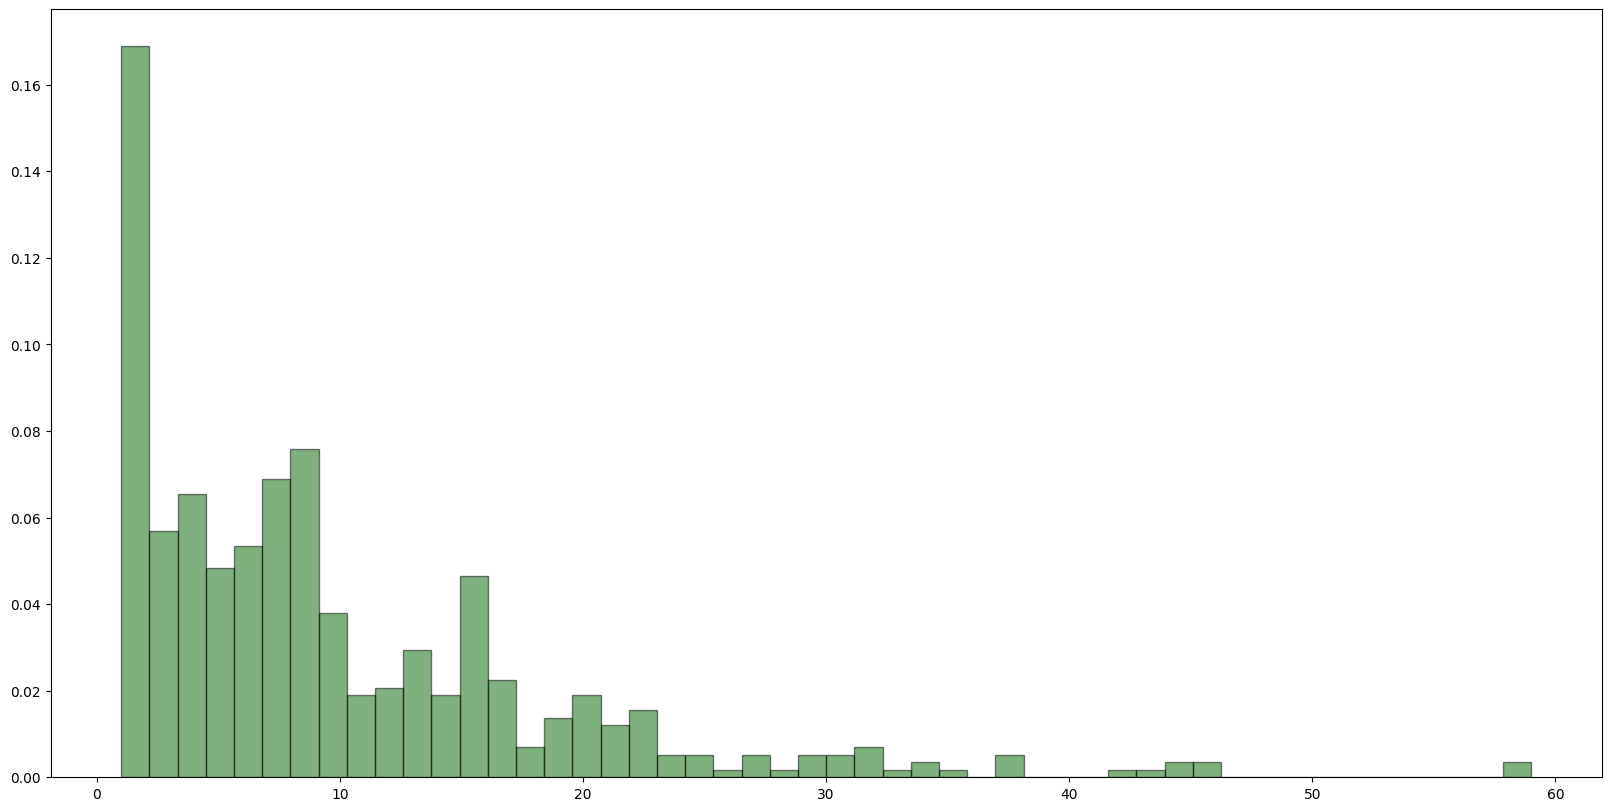

In [52]:
fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")

res = my_plotter(
    ax,
    rng.geometric(0.1, 500),
    50,
    {"color": "darkgreen", "edgecolor": "black", "alpha": 0.5},
)

### 指数分布

`random.Generator.exponential(scale=1.0, size=None)`

$$
f(x,\frac{1}{\beta}) = \frac{1}{\beta}e^{(-\frac{1}{\beta}x)}, x>0
$$

参数 `scale` 即为公式中的 $\beta$


In [25]:
rng.exponential(scale=0.5, size=10)

array([0.32826208, 0.43356883, 0.1341275 , 0.0653662 , 0.21884868,
       1.17264919, 2.10547225, 1.45651444, 0.80815348, 0.55032455])

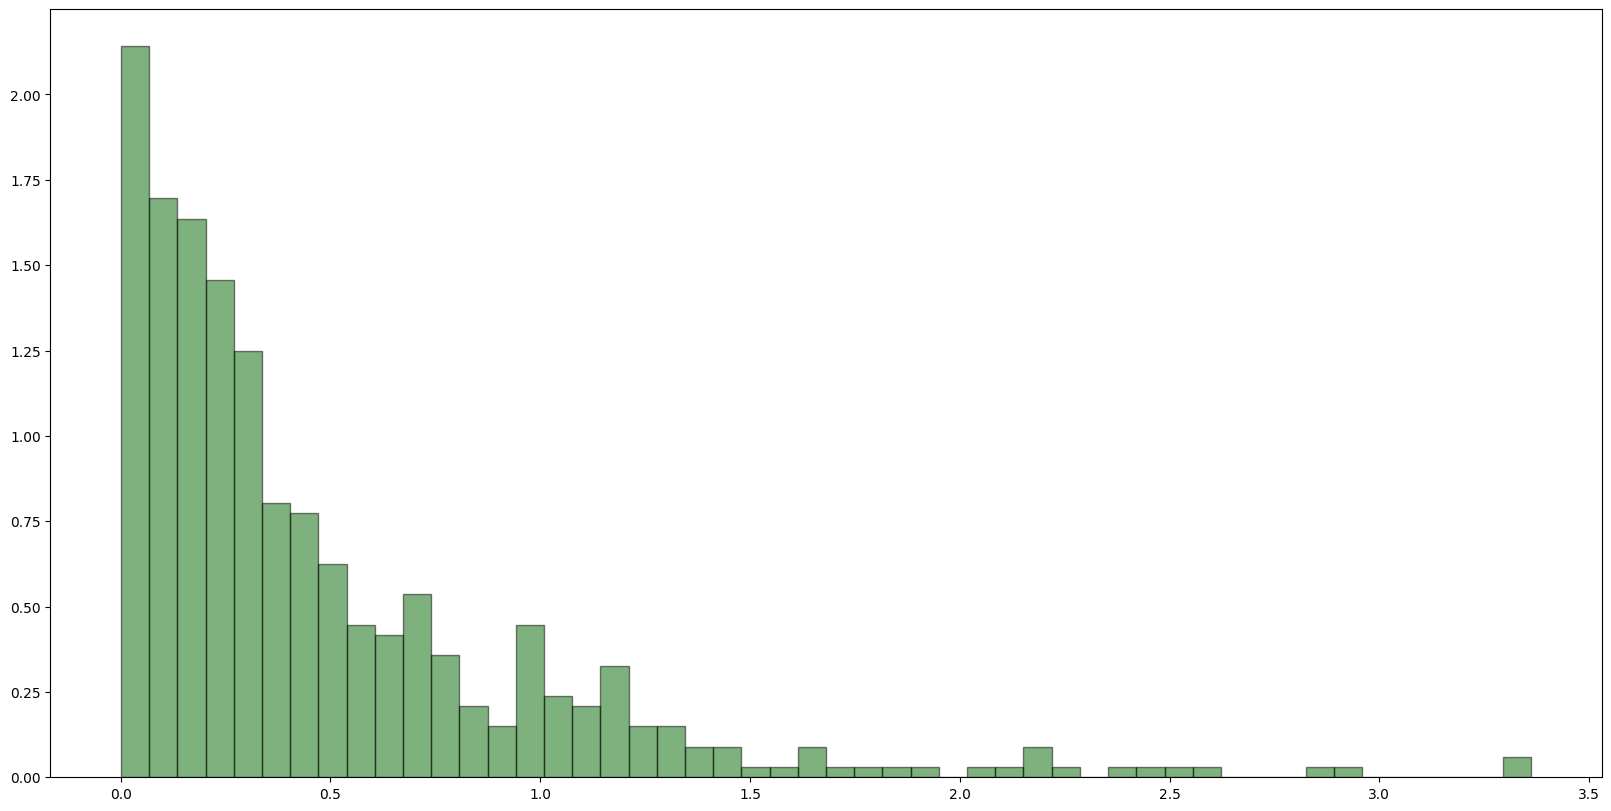

In [53]:
fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")

res = my_plotter(
    ax,
    rng.exponential(scale=0.5, size=500),
    50,
    {"color": "darkgreen", "edgecolor": "black", "alpha": 0.5},
)

### 正态分布

`random.Generator.normal(loc=0.0, scale=1.0, size=None)`

$$
f(X)= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

参数 `loc` 和 `scale` 分别为公式中的 $\mu$ 和 $\sigma$


In [26]:
rng.normal(0, 1, 20)

array([ 0.37405335, -0.02459374,  0.07726066, -0.68391322, -0.72083767,
        1.12062282, -0.05481416, -0.08241372,  0.9359865 ,  1.23853712,
        1.27279553,  0.40589222, -0.05032522,  0.28931754,  0.17930568,
        1.39748056,  0.29204679,  0.63840567, -0.02788771,  1.37105185])

numpy 提供了 `standard_nomal` 函数方便快速生成标准正态分布样本：


In [27]:
rng.standard_normal(20)

array([-2.05280763,  0.38050908,  0.75539067, -1.15912585,  2.15031011,
       -0.15027022, -0.16116428, -1.07944248,  0.87796618,  0.22446741,
       -0.59159345,  0.2262628 ,  0.68618251,  1.21500461,  0.21605944,
       -0.96482356, -0.5566078 , -2.29838764, -0.73208213,  0.7364691 ])

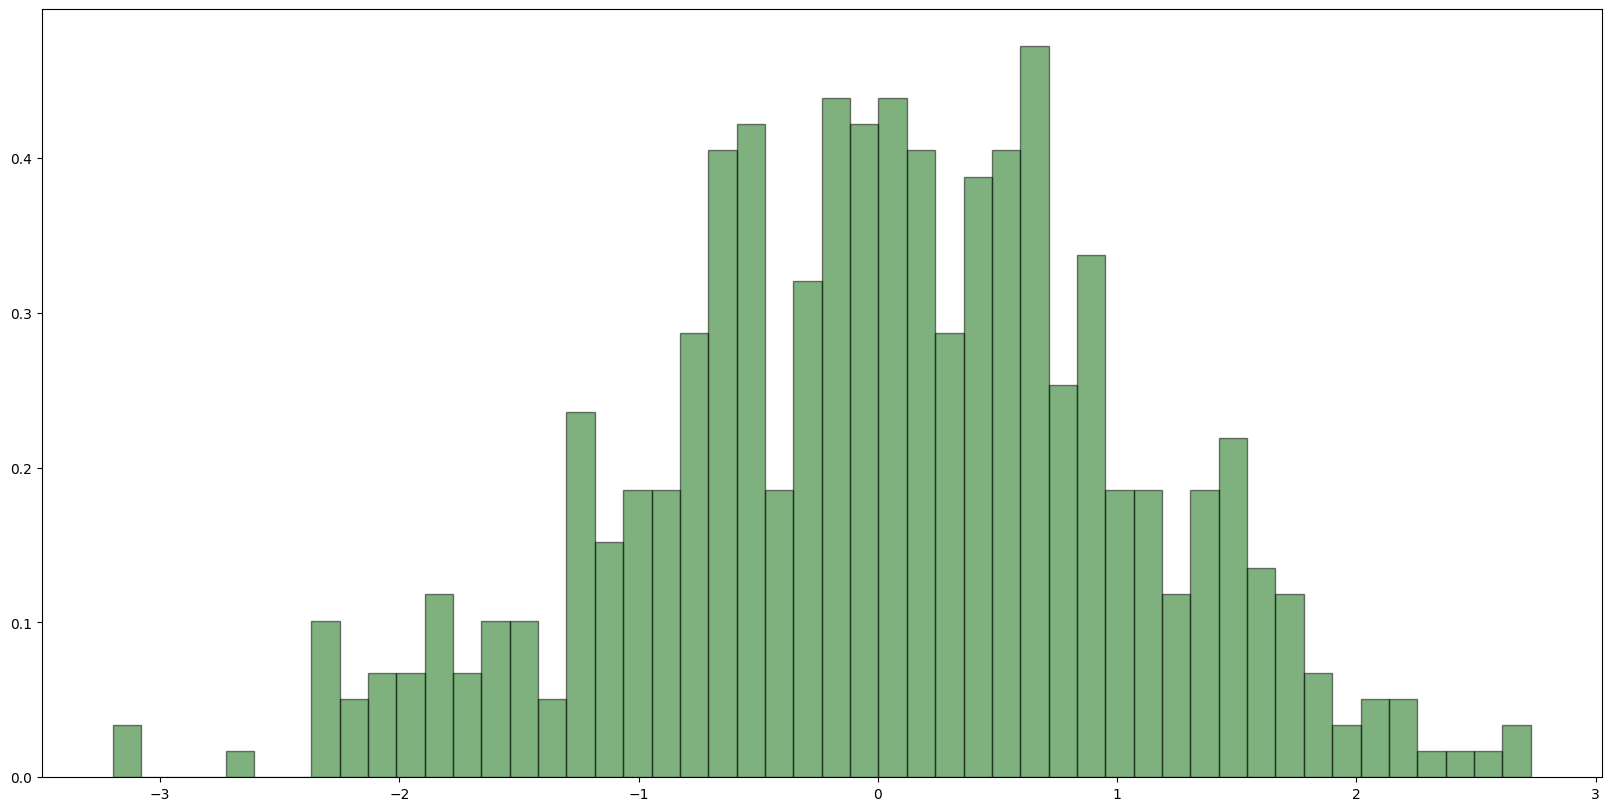

In [55]:
fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")

res = my_plotter(
    ax,
    rng.standard_normal(500),
    50,
    {"color": "darkgreen", "edgecolor": "black", "alpha": 0.5},
)

### 泊松分布

`random.Generator.poisson(lam=1.0, size=None)`

$$
f(k, \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$


In [28]:
rng.poisson(1.2, 20)

array([0, 2, 0, 1, 1, 0, 2, 1, 2, 4, 1, 1, 2, 0, 5, 1, 0, 1, 1, 1])

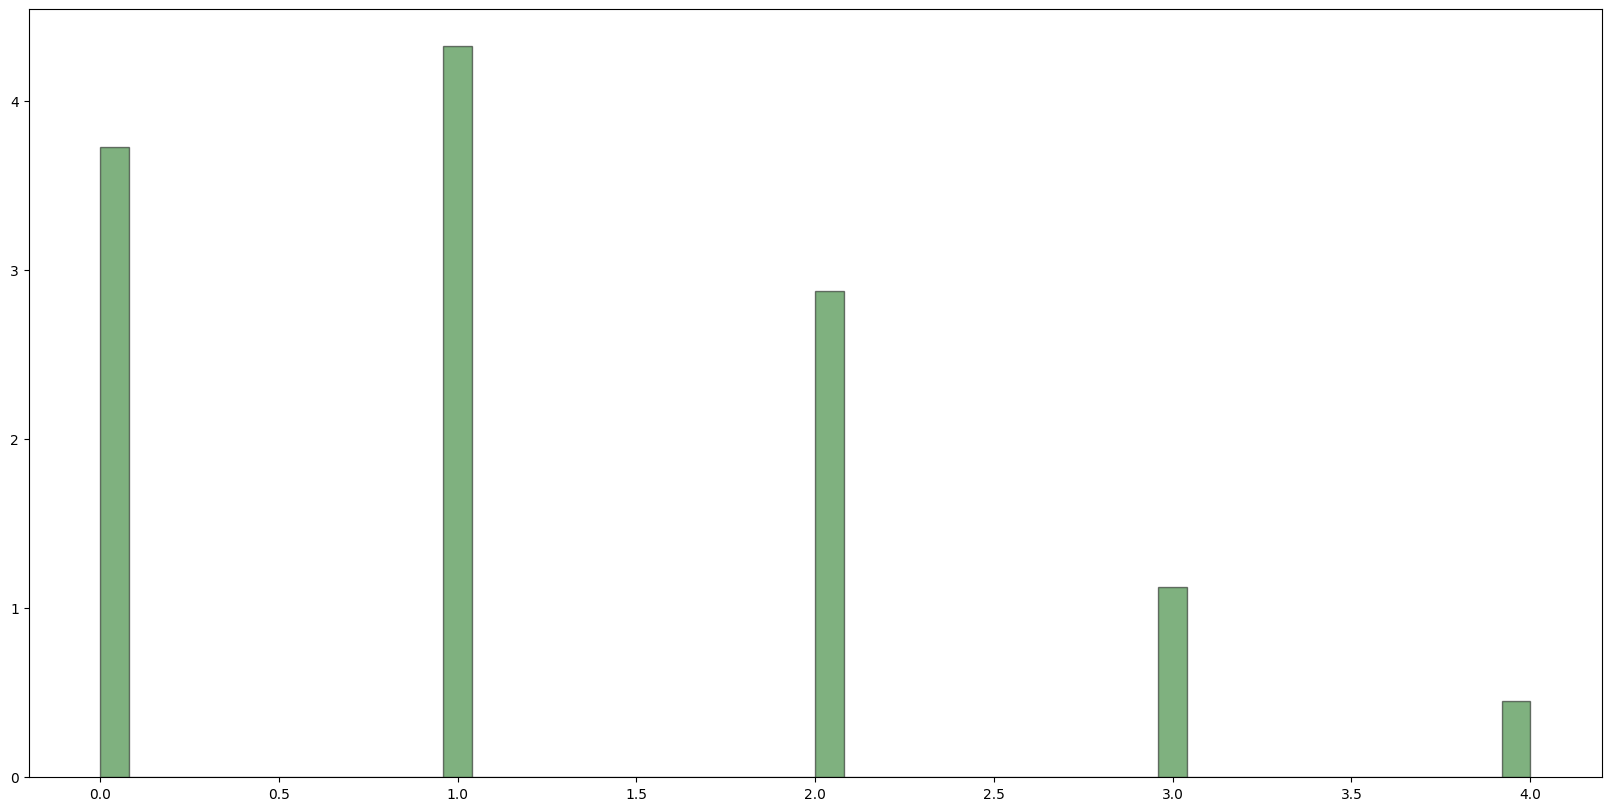

In [56]:
fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")

res = my_plotter(
    ax,
    rng.poisson(1.2, 500),
    50,
    {"color": "darkgreen", "edgecolor": "black", "alpha": 0.5},
)

### 伽马分布


# 参考资料

- https://numpy.org/doc/stable/reference/random/index.html
- https://albertcthomas.github.io/good-practices-random-number-generators/
- https://www.pcg-random.org/paper.html
- https://realpython.com/numpy-random-number-generator/
